# Table of Contents
<p>
<div class="lev1"><a href="#Data-from-the-Web"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data from the Web</a></div>
<div class="lev1"><a href="#Getting-the-data"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the data</a></div>
<div class="lev2"><a href="#Requesting-ISA-form"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Requesting ISA form</a></div>
<div class="lev2"><a href="#Finding-form-IDs"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Finding form IDs</a></div>
<div class="lev2"><a href="#Filtering-and-getting-the-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filtering and getting the data</a></div>
<div class="lev2"><a href="#Extracting-data-from-the-result-page"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extracting data from the result page</a></div>
<div class="lev2"><a href="#Treating-data"><span class="toc-item-num">3&nbsp;&nbsp;</span>Treating data</a></div>


# Data from the Web

In this homework we will extract interesting information from IS-Academia, the educational portal of EPFL. Specifically, we will focus on the part that allows public access to academic data. The list of registered students by section and semester is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need. On this form you can select the data to download based on different criteria (e.g., year, semester, etc.)

You are not allowed to download manually all the tables -- rather you have to understand what parameters the server accepts, and generate accordingly the HTTP requests. For this task, Postman with the Interceptor extension can help you greatly. I recommend you to watch this brief tutorial to understand quickly how to use it. Your code in the iPython Notebook should not contain any hardcoded URL. To fetch the content from the IS-Academia server, you can use the Requests library with a Base URL, but all the other form parameters should be extracted from the HTML with BeautifulSoup. You can choose to download Excel or HTML files -- they both have pros and cons, as you will find out after a quick check. You can also choose to download data at different granularities (e.g., per semester, per year, etc.) but I recommend you not to download all the data in one shot because 1) the requests are likely to timeout and 2) we will overload the IS-Academia server.


In [151]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import requests
import re
import scipy.stats as stats
from bs4 import BeautifulSoup
sns.set_context('notebook')

# Getting the data

## Finding ISA form 

The first part of the job in order to get the data is to get the parameters required to get the data we want.

In this purpose, we first do a get request on the ISA form with the link <http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247>.

We also use BeautifulSoup on the resulting html response in order to parse it later.

In [6]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
r.headers['content-type']
html_doc = r.text
isaForm = BeautifulSoup(html_doc, 'html.parser')

## Finding form IDs

Now that we've got the form's html code, we need to know which values of the form are used to filter and displayed the desired data. The values we're interested in are 'unité académique', 'période académique' and 'période pédagogique' (corresponding respectively to section, academic year and semester).

By inspecting the html code, we saw that the form items are 'option', it is then easy to get their value by using BeautifupSoup find and find_all method.

The following code will simply find the option value corresponding to section 'Informatique', and output it's value (the id used to filter the result).
```python
    isaForm.find('option', text = re.compile('Informatique'))['value']
```

We do the same thing for Bachelor 1st and 6th semester.
```python
    semester_ids['Bachelor semestre 1'] = isaForm.find('option', 
                                                        text = re.compile('Bachelor semestre 1'))['value']
    semester_ids['Bachelor semestre 6'] = isaForm.find('option', 
                                                        text = re.compile('Bachelor semestre 6'))['value']
```

And we get the academic years ids from 2007-2008 to 2016-2017 using a for loop (see in the cell below)

In [7]:
informatique_id = isaForm.find('option', text = re.compile('Informatique'))['value']
print("Id of informatique : ", informatique_id, "\n")

semester_ids = {}
for i in range(1, 7):
    semester_ids['Bachelor semestre ' + str(i)] = isaForm.find('option', text = re.compile('Bachelor semestre ' + str(i)))['value']

print("Id of Bachelor semester 1: ", semester_ids['Bachelor semestre 1'],"\n")
print("Id of Bachelor semester 6: ", semester_ids['Bachelor semestre 6'],"\n")

year_ids = {}
for y in range(2007, 2017):
    school_year = str(y) + "-" + str(y+1)
    year_ids[str(y) + "-" + str(y+1)] = [isaForm.find('option', text = re.compile(school_year))['value']]
    
print("years ids : (from 2007-2008 to 2016-2017)", year_ids)




Id of informatique :  249847 

Id of Bachelor semester 1:  249108 

Id of Bachelor semester 6:  942175 

years ids : (from 2007-2008 to 2016-2017) {'2010-2011': ['39486325'], '2015-2016': ['213638028'], '2012-2013': ['123456101'], '2008-2009': ['978187'], '2014-2015': ['213637922'], '2007-2008': ['978181'], '2013-2014': ['213637754'], '2011-2012': ['123455150'], '2016-2017': ['355925344'], '2009-2010': ['978195']}




## Filtering and getting the data

Now that we know the interesting IDs used in the form, we need to filter and request our data. For this purpose, we used Postman and Postman interceptor to intercept and inspect the request method used to get the data from the formula. 
  
</br>




The picture below shows all parameters used in the URL to filter and return results for:
* Section "Informatique"
* Academic period "2016-2017"
* Pedagogic period "Bachelor semestre 1"

<p>
    <img src="img/postman.png" alt="postman" align="center"/>
</p>

After playing a bit with the URL, we conclude that not all parameters were mandatory, the required parameters and their values are:

|parameter  | value |
|-----------|-------|
|ww_b_list  |must be '1'|  
|ww_i_reportmodel|must be '133685247'|
|ww_i_reportModelXsl|must be '133685270'|
|ww_x_UNITE_ACAD|correspond to the id of the section, taken from the form|
|ww_x_PERIODE_ACAD|correspond to the id of the academic year, taken from the form|
|ww_x_PERIODE_PEDAGO|correspond to the id of the semester, taken from the form|

Therefore we create a parameters dictionnary and put all the need parameters in order to get the correct URL.


In [8]:
def getFilteredPage(academic_year, semester):
    params = {'ww_b_list':'1',
            'ww_i_reportmodel':'133685247',
            'ww_i_reportModelXsl':'133685270',
            'ww_x_UNITE_ACAD':informatique_id,
            'ww_x_PERIODE_ACAD':year_ids[academic_year],
            'ww_x_PERIODE_PEDAGO':semester_ids[semester]}
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?', params)
    html_doc = r.text
    return BeautifulSoup(html_doc, 'html.parser'), params


The filter returns us a new html page containing two possibilities link to display the data. 
Since we used very precise filter in the form (specifying years, semester and section), there is only one set of data to display, meaning that both link ("Tous" and "Informatique, 'years', 'semester'") leads to the same dataset.

We choose to get the link from the "Informatique, 'years', 'semester', therefore, by inspecting the html code, we saw that the parameters used in the link was "ww_x_GPS", we simply get it from the html page for the desired data.

In [9]:
def getResultPage(academic_year, semester):
    filteredPage, params = getFilteredPage(academic_year, semester)
    params['ww_x_GPS'] = filteredPage.find_all('a')[1].get('onclick').split("ww_x_GPS=")[1].split("')")[0]
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?', params)
    return BeautifulSoup(r.text, 'html.parser')

We can then simply request the dataset, using the base URL we found thanks to Postman, the parameters used for the filter and the ww_x_GPS id.

## Extracting data from the result page

Now that we have the page displaying the desired dataset, it's time to get the interesting information out of it. 

In [42]:
def getData(academic_year, semester):
    data = getResultPage(academic_year, semester)
    students_tr = data.body.hr.table.find_all('tr')[2:]
    students = []
    for i in range (0,len(students_tr)):
        student = students_tr[i].find_all('td')
        students.append([student[0].text,student[1].text.replace(u'\xa0', u' '),student[10].text,student[7].text])

    return pd.DataFrame(students, columns=['Gender', 'Name', 'Sciper No', academic_year])

## Concatenate data

In [43]:
def getAllData(startyear, endyear, semester):
    data = getData(str(startyear) + "-" + str(startyear + 1), semester)
    for i in range(startyear, endyear):
        data = pd.merge(data, getData(str(i+1) + "-" + str(i + 2), semester), how='outer', on=['Gender','Name','Sciper No'])
    data.fillna(value='Absent')
    return data

In [163]:
Bachelor1_data = getAllData(2007, 2016, 'Bachelor semestre 1')
Bachelor5_data = getAllData(2007, 2016, 'Bachelor semestre 5')
Bachelor6_data = getAllData(2007, 2016, 'Bachelor semestre 6')

# Treating data

In [ ]:
## Treating Bachelor 1 Data

In [107]:
dataBegin = Bachelor1_data.copy()
dataBegin = dataBegin.drop(cp.columns[[0,1,2]], axis=1)
for column in cp.columns[0:]:
    year = int(column.split("-")[0])
    dataBegin[column]= dataBegin[column].replace("Présent", year, regex=True)
    dataBegin[column]= dataBegin[column].replace("Congé", year, regex=True)
    dataBegin[column]= dataBegin[column].replace("Attente", year, regex=True)

dataBegin = dataBegin.min(axis=1)

bch1_final = pd.merge(Bachelor1_data.drop(Bachelor1_data.columns[3:], axis=1), dataBegin.to_frame(),left_index=True, right_index=True)
bch1_final.columns = [['Gender', 'Name', 'Sciper No', 'Bachelor start year']]
bch1_final.head()
     

,Gender,Name,Sciper No,Bachelor start year
0,Monsieur,Arévalo Christian,169569,2007.0
1,Monsieur,Aubelle Flavien,174905,2007.0
2,Monsieur,Badoud Morgan,173922,2007.0
3,Monsieur,Baeriswyl Jonathan,179406,2007.0
4,Monsieur,Barroco Michael,179428,2007.0


In [205]:
cp = Bachelor5_data.copy()
cp = cp.drop(cp.columns[[0,1,2]], axis=1)
for column in cp.columns[0:]:
    year = float(column.split("-")[0])-0.5
    cp[column]= cp[column].replace("Présent", year, regex=True)
    cp[column]= cp[column].replace("Congé", year, regex=True)
    cp[column]= cp[column].replace("Attente", year, regex=True)

cp = cp.max(axis=1)

bch5_final = pd.concat((Bachelor5_data.drop(Bachelor5_data.columns[3:], axis=1), cp.to_frame()), axis=1)
bch5_final.columns = [['Gender', 'Name', 'Sciper No', 'Last Bachelor 5 year']]
bch5_final.head()

,Gender,Name,Sciper No,Last Bachelor 5 year
0,Madame,Andriambololona Riana Miarantsoa,154157,2006.5
1,Monsieur,Barras Florian,170220,2007.5
2,Monsieur,Bécholey Alexandre,160213,2006.5
3,Monsieur,Beuret Thibaut,166701,2007.5
4,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2007.5


In [206]:
cp = Bachelor6_data.copy()
cp = cp.drop(cp.columns[[0,1,2]], axis=1)
for column in cp.columns[0:]:
    year = float(column.split("-")[0])
    cp[column]= cp[column].replace("Présent", year, regex=True)
    cp[column]= cp[column].replace("Congé", year, regex=True)
    cp[column]= cp[column].replace("Attente", year, regex=True)

cp = cp.max(axis=1)

bch6_final = pd.concat((Bachelor6_data.drop(Bachelor6_data.columns[3:], axis=1), cp.to_frame()), axis=1)
bch6_final.columns = [['Gender', 'Name', 'Sciper No', 'Last Bachelor 6 year']]
bch6_final.head()

,Gender,Name,Sciper No,Last Bachelor 6 year
0,Monsieur,Barras Florian,170220,2008.0
1,Monsieur,Beuret Thibaut,166701,2008.0
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2008.0
3,Monsieur,Blatter Jérémy,166344,2008.0
4,Monsieur,Boksanyi Michael,161634,2007.0


In [207]:
concat = pd.merge(bch5_final, bch6_final, how='inner', on=['Gender','Name','Sciper No'])
concat.head()

,Gender,Name,Sciper No,Last Bachelor 5 year,Last Bachelor 6 year
0,Monsieur,Barras Florian,170220,2007.5,2008.0
1,Monsieur,Beuret Thibaut,166701,2007.5,2008.0
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2007.5,2008.0
3,Monsieur,Blatter Jérémy,166344,2007.5,2008.0
4,Monsieur,Boksanyi Michael,161634,2006.5,2007.0


In [218]:
endyear = concat.drop(concat.columns[[0,1,2]], axis=1).max(axis=1)
bch_end_final = pd.concat((concat.drop(concat.columns[3:], axis=1), endyear.to_frame()), axis=1)
bch_end_final.columns = [['Gender', 'Name', 'Sciper No', 'Bachelor end year']]
bch_end_final.head()

,Gender,Name,Sciper No,Bachelor end year
0,Monsieur,Barras Florian,170220,2008.0
1,Monsieur,Beuret Thibaut,166701,2008.0
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2008.0
3,Monsieur,Blatter Jérémy,166344,2008.0
4,Monsieur,Boksanyi Michael,161634,2007.0


In [219]:
AllStudentsBeginAndEnd = pd.merge(bch1_final, bch_end_final, how='inner', on=['Gender','Name','Sciper No'])
AllStudentsBeginAndEnd.head()

,Gender,Name,Sciper No,Bachelor start year,Bachelor end year
0,Monsieur,Arévalo Christian,169569,2007.0,2009.0
1,Monsieur,Aubelle Flavien,174905,2007.0,2011.0
2,Monsieur,Baeriswyl Jonathan,179406,2007.0,2010.0
3,Monsieur,Barroco Michael,179428,2007.0,2010.0
4,Monsieur,Bindschaedler Vincent,179449,2007.0,2009.0


In [226]:
bachelor_duration = (AllStudentsBeginAndEnd['Bachelor end year'] - AllStudentsBeginAndEnd['Bachelor start year']) * 2 + 2
bachelor_duration.head()

0     6.0
1    10.0
2     8.0
3     8.0
4     6.0
dtype: float64

In [227]:
gender_stats = pd.merge(AllStudentsBeginAndEnd[['Gender']], bachelor_duration.to_frame(), left_index=True, right_index=True)
gender_stats.columns = ['Gender', 'Bachelor duration [months]']
male = gender_stats.loc[gender_stats.Gender=='Monsieur']
female = gender_stats.loc[gender_stats.Gender=='Madame']

print(male.head())
print(female.head())

     Gender  Bachelor duration [months]
0  Monsieur                         6.0
1  Monsieur                        10.0
2  Monsieur                         8.0
3  Monsieur                         8.0
4  Monsieur                         6.0
    Gender  Bachelor duration [months]
15  Madame                         6.0
31  Madame                         6.0
57  Madame                         6.0
66  Madame                         6.0
69  Madame                         6.0


In [234]:
gender_stats.groupby('Gender').mean()

,Bachelor duration [months]
Gender,
Madame,6.793103
Monsieur,7.146739


In [233]:
gender_stats.describe()

,Bachelor duration [months]
count,397.000000
mean,7.120907
std,1.562015
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,14.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1816c54208>]], dtype=object)

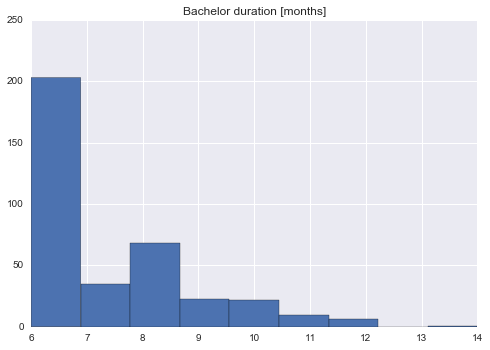

In [229]:
male.hist(bins=9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1816456748>]], dtype=object)

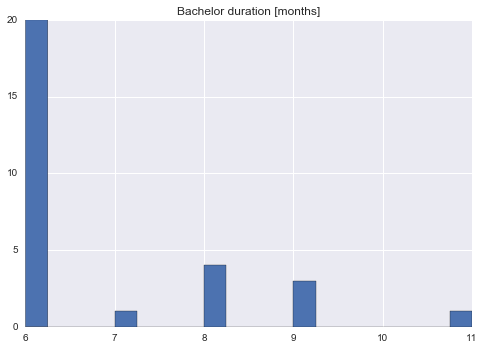

In [230]:
female.hist(bins=20)

In [231]:
stats.ttest_ind(a= male[male.columns[1]],
                b= female[female.columns[1]],
                equal_var=False)

Ttest_indResult(statistic=1.3437005678090845, pvalue=0.18785555340784144)